# KDD Data Analysis and Attack Classification using Machine Learning & Neural Networks
This notebook covers data preprocessing, feature engineering, and training multiple ML models to classify attacks using the KDD dataset.

In [1]:

import pandas as pd  # Importing pandas for data handling
import numpy as np  # Importing numpy for numerical operations
import seaborn as sns  # Importing seaborn for visualization
import matplotlib.pyplot as plt  # Importing matplotlib for plotting graphs
from sklearn.model_selection import train_test_split  # Splitting dataset into train and test
from sklearn.preprocessing import StandardScaler, LabelEncoder  # Encoding categorical variables and scaling data
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  # Importing classification models
from sklearn.svm import SVC  # Importing Support Vector Classifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  # Evaluation metrics
import tensorflow as tf  # TensorFlow for deep learning
from tensorflow import keras  # Keras API for building models
from tensorflow.keras.models import Sequential  # Sequential model type
from tensorflow.keras.layers import Dense, Dropout  # Neural network layers


## Load the KDD dataset from URL

In [2]:

# Load KDD dataset from URL
url = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz"
col_names = ["duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
             "num_failed_logins", "logged_in", "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations", "num_shells",
             "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
             "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
             "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
             "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"]

df = pd.read_csv(url, names=col_names, compression='gzip')

df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [3]:
# prompt: sample 5000 rows to make training faster

# Sample 5000 rows from the DataFrame
df = df.sample(n=5000, random_state=42)  # Use random_state for reproducibility

# Now df_sampled contains your sampled data
df.shape


(5000, 42)

## Data Preprocessing & Feature Engineering

In [4]:

# Encoding categorical variables into numeric form
encoder = LabelEncoder()
categorical_columns = ['protocol_type', 'service', 'flag']
for col in categorical_columns:
    df[col] = encoder.fit_transform(df[col])

# Convert labels into binary classification (attack or normal)
df['label'] = df['label'].apply(lambda x: 'normal' if x == 'normal.' else 'attack')
df['label'] = encoder.fit_transform(df['label'])

# Feature Engineering: Creating new features
df['byte_ratio'] = df['src_bytes'] / (df['dst_bytes'] + 1)
df['total_count'] = df['count'] + df['srv_count']
df['error_rate'] = (df['serror_rate'] + df['rerror_rate']) / 2

df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,byte_ratio,total_count,error_rate
317921,0,0,13,6,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,0,1032.000000,1022,0.0
171422,0,0,13,6,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,0,1032.000000,1022,0.0
312181,0,0,13,6,1032,0,0,0,0,0,...,1.00,0.00,0.0,0.0,0.0,0.0,0,1032.000000,1022,0.0
87346,0,1,18,6,345,5419,0,0,0,0,...,0.01,0.02,0.0,0.0,0.0,0.0,1,0.063653,12,0.0
57449,0,1,31,3,0,0,0,0,0,0,...,0.00,0.00,1.0,1.0,0.0,0.0,0,0.000000,262,0.5


## Splitting Data into Training and Testing Sets

In [5]:

X = df.drop('label', axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Training Machine Learning Models
Random Forest Classifiers:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Gradient Boosting Classifier:
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

Support Vector Classifier:
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#

In [6]:

# RandomForest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Gradient Boosting Classifier
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb))

# Support Vector Machine (SVM)
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Random Forest Accuracy: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

Gradient Boosting Accuracy: 0.997
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      1.00      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000

SVM Accuracy: 0.994
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      0.98      0.98       192

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99 

## Building a Neural Network Classifier

In [7]:

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


C:\Users\SP1700\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7976 - loss: 0.4763 - val_accuracy: 0.9940 - val_loss: 0.0682
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.1037 - val_accuracy: 0.9930 - val_loss: 0.0557
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0498 - val_accuracy: 0.9950 - val_loss: 0.0615
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0381 - val_accuracy: 0.9950 - val_loss: 0.0786
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0318 - val_accuracy: 0.9950 - val_loss: 0.0837
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9926 - loss: 0.0243 - val_accuracy: 0.9950 - val_loss: 0.0917
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9945 - loss: 0.0175 - val_accuracy: 0.9950 - val_loss: 0.0962
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9971 - loss: 0.0201 - val_accuracy: 0.9950 - val_

## Evaluating Neural Network Performance

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Neural Network Accuracy: 0.996
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       808
           1       0.98      0.99      0.99       192

    accuracy                           1.00      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       1.00      1.00      1.00      1000



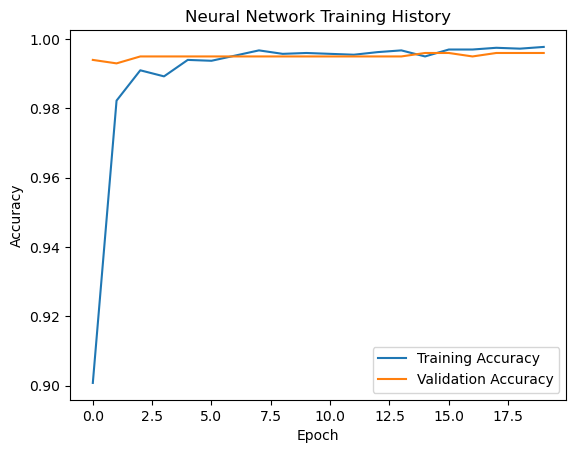

In [8]:

y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred_nn))
print(classification_report(y_test, y_pred_nn))

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Neural Network Training History')
plt.show()


Based on the above code, write your own code to develop other ML or Neural network algorithms from list below.

Machine Learning Algorithms
**bold text**
Decision Tree Classifier:  https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

K-Nearest Neighbors (KNN):  https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

Naive Bayes Classifier: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html


**Deep Learning Models**
Long Short-Term Memory (LSTM): https://keras.io/api/layers/recurrent_layers/lstm/

Convolutional Neural Networks (CNN): https://keras.io/api/layers/convolution_layers/convolution1d/

Transformers (Hugging Face Transformers)

**Important: Lab-Logbbok requirement**

Provide a bar graph comparing accuracy, precicion, recall, and f-score for various AI models



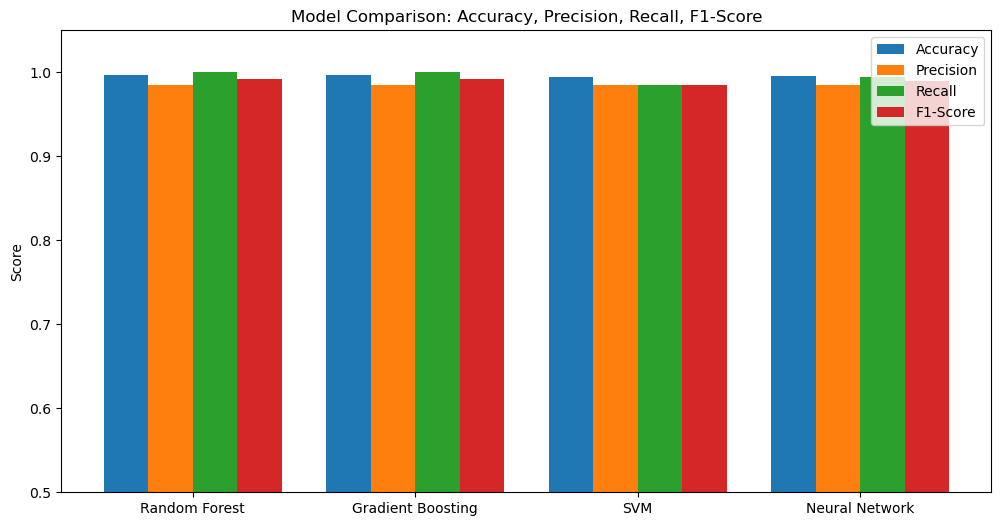

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def plot_model_comparison_metrics(y_test, predictions_dict):
    models = list(predictions_dict.keys())
    
    accuracies = [accuracy_score(y_test, predictions_dict[model]) for model in models]
    precisions = [precision_score(y_test, predictions_dict[model]) for model in models]
    recalls = [recall_score(y_test, predictions_dict[model]) for model in models]
    f1_scores = [f1_score(y_test, predictions_dict[model]) for model in models]
    
    x = np.arange(len(models))
    width = 0.2

    plt.figure(figsize=(12, 6))
    plt.bar(x - 1.5 * width, accuracies, width, label='Accuracy')
    plt.bar(x - 0.5 * width, precisions, width, label='Precision')
    plt.bar(x + 0.5 * width, recalls, width, label='Recall')
    plt.bar(x + 1.5 * width, f1_scores, width, label='F1-Score')

    plt.xticks(x, models)
    plt.ylabel('Score')
    plt.title('Model Comparison: Accuracy, Precision, Recall, F1-Score')
    plt.ylim(0.5, 1.05)
    plt.legend()
    plt.show()

predictions = {
    'Random Forest': y_pred_rf,
    'Gradient Boosting': y_pred_gb,
    'SVM': y_pred_svm,
    'Neural Network': y_pred_nn
}

plot_model_comparison_metrics(y_test, predictions)

